In [51]:
import json
import numpy as np
import random
from tqdm import tqdm
import nltk
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
import pandas as pd
from sklearn.decomposition import PCA
import re
import matplotlib.pyplot as plt
import sklearn

In [2]:
def rand_emot():
    e = ["(o_o)",":-)",":P",":D","x)","ᓚᘏᗢ","╯°□°）╯︵ ┻━┻",":)",
         "*<:-)","^_^","(⌐■_■)","¯\_(ツ)_/¯", "(T_T)",":o","OwO",
        "( ͡❛ ͜ʖ ͡❛)","(̶◉͛‿◉̶)","( ≖.≖)","(ㆆ_ㆆ)","ʕ•́ᴥ•̀ʔっ","( ◡́.◡̀)","(^◡^ )"]
    return random.choice(e)

def load_files():
    text_pairs = [] #Would be nice to have as np.array
    labels = []
    fandom = []
    
    pair_id = []
    true_id = []
    
    #Load truth JSON
    for line in open('data/modified/train_truth.jsonl'):
        d = json.loads(line.strip())
        labels.append(int(d['same']))
        true_id.append(d['id'])

    #Load actual fanfic.
    print("loading fanfic...",rand_emot())
    for line in tqdm(open('data/modified/train_pair.jsonl')):
        d = json.loads(line.strip())
        text_pairs.append(d['pair'])
        fandom.append(d['fandoms'])
        pair_id.append(d['id'])

    print("done loading",rand_emot())
    
    return text_pairs, labels, fandom, pair_id, true_id

In [3]:
text_pairs, labels, fandom, pair_id, true_id = load_files()

116it [00:00, 1151.59it/s]

loading fanfic... x)


1578it [00:01, 1214.29it/s]

done loading (o_o)


In [67]:
def word_freq(text_pair):
    fdist0 = nltk.FreqDist(text_pair[0])
    fdist1 = nltk.FreqDist(text_pair[1])
    
    return [fdist0, fdist1]

def word_freq_single(text):
    fdist = nltk.FreqDist(text)
    return fdist

def tokenize(text_pair):
    return [nltk.word_tokenize(text_pair[0]),nltk.word_tokenize(text_pair[1])]

def vector_freq_dist(freq_dists): #I don't think this works...
    return [list(freq_dists[0].values()), list(freq_dists[1].values())]

def cosine_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [44]:
def create_corpus(text_pairs):
    '''input all text pairs to create a corpus'''
    corpus = [x[i] for x in text_pairs for i in range(len(x))]
    return corpus

def fit_tfidf(corpus):
    vectorizer = TfidfVectorizer()
    print("training vectorizer...",rand_emot())
    X = vectorizer.fit_transform(corpus)
    print("vectorizer fit!", rand_emot())
    
    
    df = pd.DataFrame(X[0].T.todense(), index=vectorizer.get_feature_names(), columns=["TF-IDF"])
    df = df.sort_values('TF-IDF', ascending=False)
    
    return X, df

In [45]:
corpus = create_corpus(text_pairs)

In [46]:
#tf-idf on the raw text. Likely not useful, as you can see, it is sesnitive to the fandom.
raw_tfidf, tfidf_df = fit_tfidf(corpus)

training vectorizer... (ㆆ_ㆆ)
vectorizer fit! ( ͡❛ ͜ʖ ͡❛)


In [68]:
tfidf_df.head(10)

,TF-IDF
the,0.389299
to,0.295670
kuroko,0.283424
judgement,0.247891
was,0.184794
and,0.182388
it,0.182330
that,0.172474
she,0.169618
her,0.146488


In [18]:
#Attempting to perform tf-idf on only symbols.
def isolate_symbols(corpus):
    #Add \d to omit digits too.
    sym_corpus = []
    for text in corpus:
        sym_corpus.append(' '.join(re.findall("[^a-zA-Z\s]+", text)))
    return sym_corpus

symbols = isolate_symbols(corpus)

#Okay, tf-idf doesn't work with symbols. I'll convert them to made-up words

In [22]:
symbols[0]

'. " , . , , . . " . " ?! ?! , - !" , . " . . - ." . , . , . , . - - . " . , . , , . ... , . , . , . " , . , . " " . " , " . " , - , " . ". ? , ." , . , , , ... ... . " . , " . , ?" , " . , . " , , " . ... . " . , . , " . , ? , " ! ?" , . , , . " ..." , . "... ! , ? , " " . , . ... !" , . " ? ." , , . , ... , . . " , ?" , " . " -! , . " , , -!" . . - . . " , . " " , . , . " . " , " . , . " , " . , " - . - . ... . " ... " . , , . , , - , . , . , . , , " . , , . . " - . ?! ?!" . . " , . , " , " . ... ? , " . " - . ?! ?!" . , . ... . , , . ... . " , . , , - . , , - - . , , , . , . - " , . " . , , ? ?" , , " . " , " . , . , ." , . , , . , , , . , . , , " . " . " , ? , " ." . " " ", " . " !" " . " , ? " - ? ?" . ... " " . , . , - , " " . " - , !" "... , ?" . . , . ... " . ... " ? "... , . , " ." " " !" - , . " . " , , . " - " . " . , , " . , , - " ", " . , " , " " . " . , . " , . . " , . . " " !" , . , . "... ?" , . " ... , . . " ... " ! , ! !" "... . , " , ?" . " , " . . " . , . " ... " " 

In [70]:
#Whack function that converts symbols to letters...
def symbol2word(symbols):
    '''Takes in set of symbols and convert them to unique words'''
    symbols = list(symbols)
    sym2word = {}
    chars = [0,0,0]
    
    for i in range(len(symbols)):
        chars[2] = add_one(chars[2])
        
        if chars[2] % 58 == 0:
            chars[1] = add_one(chars[1])
            chars[2] = 0
        
        if chars[1] % 58 == 0 and chars[1] != 0:
            chars[0] = add_one(chars[0])
            chars[1] = 0
        
        
        sym2word[symbols[i]] = 'XX'+chr(chars[0]+65)+chr(chars[1]+65)+chr(chars[2]+65)
    
    return sym2word

def add_one(x):
    if x == 91-66:
        return x + 7
    return x + 1

def replace_symbols(symwords, corpus):
    for i, text in tqdm(enumerate(corpus)):
        text = nltk.word_tokenize(text)
        text = replace(text, symwords)
        corpus[i] = text
    return corpus

def replace(tokens, dictionary):
    return [dictionary.get(item, item) for item in tokens]

def chunk_replace(corpus):
    start = 0
    for i in range(0,int(len(corpus)/100),100):
        corpus[start:i] = replace_symbols(symwords, corpus[start:i])
        start = i
    corpus[start:] = replace_symbols(symwords, corpus[start:])
    
    return corpus

In [71]:
#Convert symbols to words
symwords = symbol2word(set(symbols))

#DESTROY corpus by replacing symbols with their word.
corpus = replace_symbols(symwords, corpus)

3156it [01:55, 27.41it/s]


In [72]:
print("joining corpus...",rand_emot())
tfidf_sym, sym_df = fit_tfidf([' '.join(x) for x in corpus])

joining corpus... ╯°□°）╯︵ ┻━┻
training vectorizer... OwO
vectorizer fitted! (⌐■_■)


In [73]:
sym_df.head(10)

,TF-IDF
xxaeq,0.495362
xxadh,0.470565
the,0.281537
to,0.213825
kuroko,0.204969
judgement,0.179272
was,0.133641
and,0.131901
it,0.131859
that,0.124731


In [ ]:
key_list = list(symwords.keys())
val_list = list(symwords.values())

key_list[val_list.index('XXADM')], key_list[val_list.index('XXAAE')]

In [20]:
## POS Tagging and ngrams
tokens = nltk.word_tokenize(corpus[0])
pos_tags = nltk.pos_tag(tokens)
pos_bigrams = nltk.bigrams(pos_tags)

In [32]:
def compute_lix(text):
    tokens = nltk.word_tokenize(text)
    splt = text.split()
    o = len(splt)+1
    p = len([x for x in tokens if x=='.'])+1
    l = len([x for x in tokens if len(x)>6])+1
    
    return (o/p)+((l*100)/o)

In [33]:
for text in corpus[:10]:
    print(compute_lix(text))

29.910954831914932
30.709476503232075
34.64747315241397
31.16576505295295
35.736950980754315
27.826830313919487
23.657931484369428
30.435502148277408
29.67444070920108
27.62315961549868


In [34]:
def tokenize_no_symbols(text):
    return nltk.word_tokenize(re.sub(r'[^\w]', ' ', text))

def get_fdist_yule(text):
    text = tokenize_no_symbols(text)
    fdist = word_freq_single(text)
    return fdist
        
def get_num_unique_words(text):
    text = tokenize_no_symbols(text.lower())
    return len(set(text))
        
def yules_k(text):
    C = 10000
    splt = text.split()
    N = len(splt)
    Vn = get_num_unique_words(text)
    fdist = get_fdist_yule(text)
    max_word = fdist.most_common()[0][1]
    
    var = 0
    
    for m in range(max_word):
        Vmn = len([x for x in fdist if fdist[x]==m])
        mNs = np.power(m/N,2)
        
        var += Vmn*mNs
    
    return C*(-1/N+var)
        
        

In [35]:
#I am not 100% sure I implemented Yule's K the right way. 
for i in corpus[:10]:
    k,lix = yules_k(i), compute_lix(i)
    print(k, lix, k-lix)

54.62083541967105 29.910954831914932 24.70988058775612
50.06509040692571 30.709476503232075 19.355613903693637
68.87825528810403 34.64747315241397 34.230782135690056
69.87291123035095 31.16576505295295 38.707146177398
57.89319891883996 35.736950980754315 22.15624793808564
67.16115024294662 27.826830313919487 39.33431992902713
63.76863861014663 23.657931484369428 40.1107071257772
85.34784357474064 30.435502148277408 54.91234142646323
52.83657559952693 29.67444070920108 23.162134890325852
59.121650604821426 27.62315961549868 31.498490989322747


In [37]:
#We can also use CountVectorizer
c_vec = CountVectorizer()
cX = c_vec.fit_transform(corpus)
cX.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [38]:
#Hmmm... 
tfidf_vec = TfidfVectorizer()
tfidfX = tfidf_vec.fit_transform(corpus)
tfidfX.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [39]:
logreg = LogisticRegression(max_iter=1000)
cx_arr = cX.toarray()
cvec_pairs = [np.concatenate([cx_arr[x],cx_arr[x+1]]) for x in range(0,len(cx_arr),2)]

cvec_train, cvec_test, labels_train, labels_test = train_test_split(cvec_pairs, labels)
len(cvec_train)

1183

In [40]:
#Slow!
logreg.fit(cvec_train, labels_train)

KeyboardInterrupt: 

In [ ]:
#62% accuracy just from word freq on raw text.
logreg.score(cvec_test, labels_test)

In [47]:
tfidf_arr = tfidfX.toarray()
tfidf_pairs = [np.concatenate([tfidf_arr[x],tfidf_arr[x+1]]) for x in range(0,len(tfidf_arr),2)]

tf_train, tf_test, tf_labels_train, tf_labels_test = train_test_split(tfidf_pairs, labels)
len(tf_train)

1183

In [ ]:
#64% accuracy on tfidf on raw text.
logreg.fit(tf_train, tf_labels_train)
logreg.score(tf_test, tf_labels_test)

In [ ]:
#BAD result!
logreg.fit(np.hstack([tf_train,cvec_train]), tf_labels_train)
logreg.score(np.hstack([tf_test,cvec_test]), tf_labels_test)

In [ ]:
tfsym_arr = tfidfX.toarray()
tfsym_pairs = [np.concatenate([tfsym_arr[x],tfsym_arr[x+1]]) for x in range(0,len(tfsym_arr),2)]

tfsym_train, tfsym_test, tfsym_labels_train, tfsym_labels_test = train_test_split(tfsym_pairs, labels)

In [ ]:
#61% 
logreg.fit(tfsym_train, tfsym_labels_train)
logreg.score(tfsym_test, tfsym_labels_test)

In [ ]:
lix_vec = np.array([compute_lix(x) for x in corpus])
yule_vec = np.array([yules_k(x) for x in corpus])

In [ ]:
lix_pairs = [np.hstack([lix_vec[x],lix_vec[x+1]]) for x in range(0,len(lix_vec),2)]
lix_train, lix_test, lix_labels_train, lix_labels_test = train_test_split(lix_pairs, labels)

yule_pairs = [np.hstack([yule_vec[x],yule_vec[x+1]]) for x in range(0,len(yule_vec),2)]
yule_train, yule_test, yule_labels_train, yule_labels_test = train_test_split()

In [ ]:
logreg.fit(lix_train, lix_labels_train)
logreg.score(lix_test, lix_labels_test)

In [57]:
def plot_pcs(pcs, target, labels, ctitle=""):   
    group1 = pcs[target==0]
    group2 = pcs[target==1]
    
    plt.scatter(group1[:,0], group1[:,1], cmap='jet', label=labels[0], s=8)
    plt.scatter(group2[:,0], group2[:,1], cmap='jet', label=labels[1], s=2)
    
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.legend(loc="best")
    plt.title(ctitle)

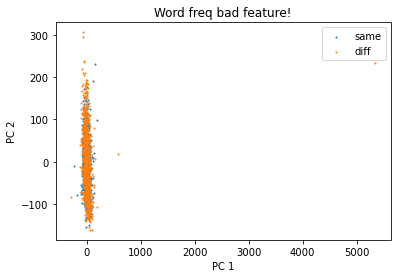

In [42]:
pca = PCA(n_components=2)
cx_arr = cX.toarray()
cvec_pairs = [np.concatenate([cx_arr[x],cx_arr[x+1]]) for x in range(0,len(cx_arr),2)]

pcs = pca.fit_transform(cvec_pairs)

plot_pcs(pcs, np.array(labels), ("same", "diff"), ctitle="Word freq bad feature!")

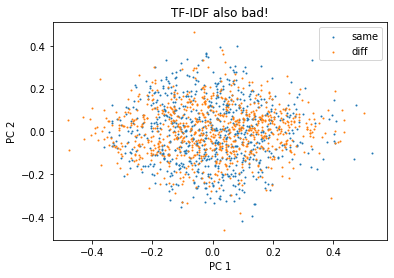

In [48]:
tf_pcs = pca.fit_transform(tfidf_pairs)
plot_pcs(tf_pcs, np.array(labels), ("same", "diff"), ctitle="TF-IDF also bad!")

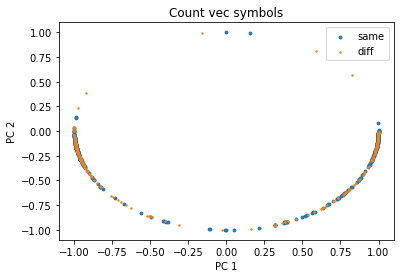

In [62]:
sym_countvec = CountVectorizer()
sym_arr = sym_countvec.fit_transform(symbols).toarray()

sym_pairs = [np.concatenate([sym_arr[x],sym_arr[x+1]]) for x in range(0,len(sym_arr),2)]

sym_pcs = pca.fit_transform(sym_pairs)
plot_pcs(sklearn.preprocessing.normalize(sym_pcs), np.array(labels), ("same", "diff"), ctitle="Count vec symbols")

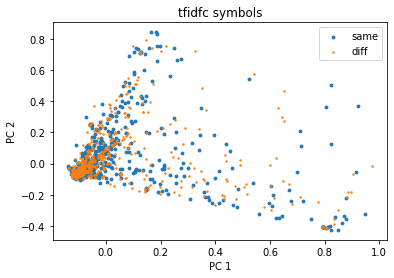

In [69]:
sym_countvec = TfidfVectorizer()
sym_arr = sym_countvec.fit_transform(symbols).toarray()

sym_pairs = [np.concatenate([sym_arr[x],sym_arr[x+1]]) for x in range(0,len(sym_arr),2)]

sym_pcs = pca.fit_transform(sym_pairs)
plot_pcs(sym_pcs, np.array(labels), ("same", "diff"), ctitle="tfidf symbols")

In [79]:
cos_sym_pairs = np.array([cosine_sim(x,x+1) for x in range(0,len(sym_arr),2)])
                         #Hmmm

sym_pcs = pca.fit_transform(cos_sym_pairs)
#plot_pcs(sym_pcs, np.array(labels), ("same", "diff"), ctitle="cosine tfidf symbols")

c:\python37\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


ValueError: Expected 2D array, got 1D array instead:
array=[nan  1.  1. ...  1.  1.  1.].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [150]:
def get_sent_word_length(text):
    #Function, which removes symbols and count words in sentence
    #Output: length of each sentence & length of each word
    sentences = re.split('[\.+|!|?]', text)
    sentences = [re.sub(r"[^\w]+", ' ', x) for x in sentences if len(x.strip()) != 0]
    word_sentences = [nltk.word_tokenize(x) for x in sentences]
    sentence_lengths = np.array([len(x) for x in word_sentences])
    word_lengths = np.array([len(s) for x in word_sentences for s in x])
    return sentence_lengths, word_lengths

get_sent_word_length(corpus[0])

(array([ 7, 10, 17,  7, 13,  3,  3, 10, 20,  2,  7,  4,  3, 13, 16, 17, 27,
         6, 13, 20,  1, 22, 20, 15, 14, 12,  7, 14, 15,  7,  1,  9, 15, 21,
         5,  2, 14,  3, 23,  8, 11,  1,  6, 12,  9,  8,  8,  3,  9, 14,  1,
         8,  0,  2,  3, 14,  6,  2,  3,  8,  2,  2, 12,  9, 15,  2, 17, 17,
         4, 14,  8,  7, 23, 11,  3, 18, 23,  6,  7, 23, 24, 34, 10,  2,  2,
        12,  2,  5, 11, 14,  4, 12, 16, 17, 12,  2,  3,  3,  2,  6, 24, 26,
         1,  3, 23,  2,  3,  3,  2, 26,  2,  5, 23,  3,  7, 15, 29, 22, 25,
        11,  4, 10,  8,  4, 33,  5,  7,  7,  8, 20, 27, 15, 18, 13, 10, 12,
         4, 13, 17, 11,  2, 13,  9,  2,  5, 11, 20, 29, 19,  0,  3,  2,  4,
        14,  1,  9,  3,  8,  0,  2,  8,  5, 19,  8, 17, 21, 17, 16, 21, 26,
         9,  5, 32,  6, 13, 15,  3, 17, 29,  0,  4, 10,  1,  7,  3,  2,  4,
        13,  5,  0,  1, 14,  3, 24, 10,  1,  3,  2, 18,  1,  4,  2, 18,  5,
        25,  2,  5,  4,  2, 25,  8,  1,  8,  5,  6, 10,  2,  1,  2, 10, 19,
         0, 

In [137]:
l = [['her', 'er', 'liste'],
    ['her', 'er', 'liste2']]
[len(s) for x in l for s in x]

[3, 2, 5, 3, 2, 6]

In [98]:
re.strip()

AttributeError: module 're' has no attribute 'strip'